In [14]:
# Important libaries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [15]:
# plot Accurcy graph for model tuning?
plot_knn_accuracy = False
plot_logreg_accuracy = False

In [16]:
# Read TSV data
columns = ["ID", "label_6", "statement", "subject", "speaker", "speaker_job", "state", "party", "pof_count", "false_count", "barelytrue_count", "halftrue_count", "mostlytrue_count", "context"]
train_data = pd.read_table("/kaggle/input/LIARbyYang/train.tsv", header = None, names = columns)
v_data = pd.read_table("/kaggle/input/LIARbyYang/valid.tsv", header = None, names = columns)
test_data = pd.read_table("/kaggle/input/LIARbyYang/test.tsv", header = None, names = columns)


Here we do not want to merge the three tables provided. Next, check the data:

In [17]:
train_data.head(10)

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


In [18]:
train_data.shape

(10240, 14)

# Relabel

We want to merge the labels from 6-ways to 2 and 3-ways, while keeping the original 6-ways labels for the benchmark.

In [19]:
merger_2 = { 'pants-fire' : 0,
           'false' : 0,
           'barely-true': 0,
           'half-true': 0,
           'mostly-true': 1,
           'true': 1}
merger_3 = { 'pants-fire' : 0,
           'false' : 0,
           'barely-true': 1,
           'half-true': 1,
           'mostly-true': 2,
           'true': 2}
merger_6 = { 'pants-fire' : 0,
           'false' : 1,
           'barely-true': 2,
           'half-true': 3,
           'mostly-true': 4,
           'true': 5}

# training set
train_data['label_2'] = train_data["label_6"].map(merger_2)
train_data['label_3'] = train_data["label_6"].map(merger_3)
train_data["label_6"].replace(merger_6, inplace = True)

# cross validation set
v_data['label_2'] = v_data["label_6"].map(merger_2)
v_data['label_3'] = v_data["label_6"].map(merger_3)
v_data["label_6"].replace(merger_6, inplace = True)

# test set
test_data['label_2'] = test_data["label_6"].map(merger_2)
test_data['label_3'] = test_data["label_6"].map(merger_3)
test_data["label_6"].replace(merger_6, inplace = True)

# check
train_data.head(10)

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,context,label_2,label_3
0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0,0
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0,1
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1,2
3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0,0
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0,1
5,12465.json,5,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,1,2
6,2342.json,2,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,0,1
7,153.json,3,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",0,1
8,5602.json,3,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,0,1
9,9741.json,4,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,1,2


# Bag of Words Process

In [20]:
# tokenization processes


from nltk.corpus import stopwords
import string
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
from nltk.stem.snowball import SnowballStemmer
stemmer=SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

# remove stopwords
def remove_stopwords(list_of_tokens):
    new_list_of_tokens = [w for w in list_of_tokens if not w.lower() in stop_words]
    return new_list_of_tokens

# remove punctutations and tokens with less than two in length
def remove_punctuations_shortwords(list_of_tokens):
    translation = str.maketrans('', '', string.punctuation)
    new_list_of_tokens = [tokens.translate(translation) for tokens in list_of_tokens if len(tokens.translate(translation))>=3]
    return new_list_of_tokens

def tokenize_and_stem(Pandas_Series):
    Pandas_Series = Pandas_Series.replace('\d+', '', regex=True) # remove numbers
    Pandas_Series = Pandas_Series.apply(nltk.word_tokenize) # tokenize statement
    Pandas_Series = Pandas_Series.apply(remove_stopwords) # remove stopwords
    Pandas_Series = Pandas_Series.apply(remove_punctuations_shortwords) # remove punctutations and tokens with less than two in length
    Pandas_Series = Pandas_Series.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return Pandas_Series

In [21]:
train_data['stemmed_statement_token'] = tokenize_and_stem(train_data['statement']) # Process statement strings

See sentence length distribution:

<Axes: xlabel='stemmed_statement_token', ylabel='Count'>

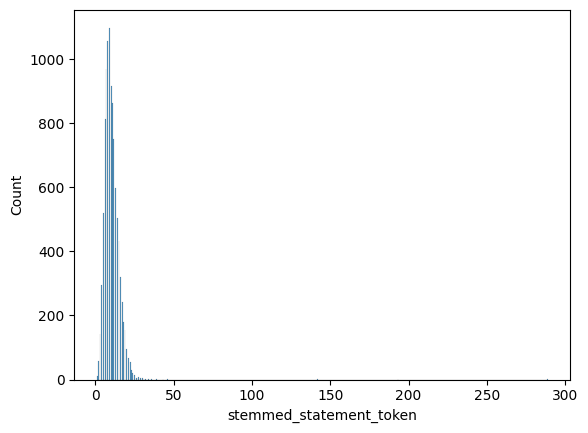

In [22]:
sns.histplot(train_data['stemmed_statement_token'].str.len())

One can see that there are some outlier sentences that exceed 30 tokens. Our approach is not to get rid of their records, but to exclude them from the CountVecterizer fitting. To do that, we keep the index of instances with statements having too much tokens.

In [23]:
statement_index_tofit = train_data['stemmed_statement_token'].str.len() < 30
train_data[-statement_index_tofit] # instances with very long statements

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,mostlytrue_count,context,label_2,label_3,stemmed_statement_token
355,1616.json,3,Last week the Texas State Board of Education (...,education,bill-white,Former mayor of Houston,Texas,democrat,2.0,3.0,5.0,7.0,3.0,an e-mail,0,1,"[last, week, texa, state, board, educ, sboe, l..."
427,7176.json,4,Right now one of our highest job growth sector...,"economy,jobs,labor",lou-greenwald,State Assemblyman,New Jersey,democrat,0.0,1.0,1.0,2.0,2.0,a press conference in Trenton,1,2,"[right, one, highest, job, growth, sector, lei..."
1280,1606.json,4,"Hospitals, doctors, MRIs, surgeries and so for...","elections,ethics,states",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,a debate on Fox News Sunday,1,2,"[hospit, doctor, mris, surgeri, forth, extens,..."
2142,638.json,1,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,"[fact, although, presid, oppos, abort, last, e..."
3300,7538.json,3,Says we will pay the new chancellor a basic sa...,"education,state-finances",gene-mcintyre,NaN,NaN,none,0.0,0.0,1.0,0.0,0.0,a guest column,0,1,"[say, pay, new, chancellor, basic, salari, nea..."
4034,13194.json,2,Mike Madigan made a fortune on tax appeals Sav...,taxes,citizens-michael-mcauliffe-and-house-republica...,NaN,Illinois,republican,1.0,0.0,0.0,0.0,0.0,a video attack advertisement,0,1,"[mike, madigan, made, fortun, tax, appeal, sav..."
4193,29.json,5,Let's pay attention to kids who are not going ...,economy,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,NaN,1,2,"[let, pay, attent, kid, go, colleg, end, perce..."
5156,7638.json,4,"Under Republican Chris Christie, New Jersey ha...","economy,jobs,states",one-new-jersey,NaN,NaN,democrat,0.0,0.0,1.0,2.0,0.0,a TV ad,1,2,"[republican, chris, christi, new, jersey, high..."
5531,1489.json,1,Says state Sen. Steve Ogden was the driving fo...,"education,guns,state-budget",ben-bius,Businessman,Texas,republican,0.0,1.0,0.0,0.0,0.0,a radio advertisement.,0,0,"[say, state, sen, steve, ogden, drive, forc, b..."
6119,1993.json,5,Georgia has the most restrictive ballot access...,crime,dan-gelber,NaN,Florida,democrat,2.0,2.0,1.0,3.0,0.0,his campaign blog,1,2,"[georgia, restrict, ballot, access, law, count..."


See the most common (and potentially useless) words for the dataset, check for redundant words:

In [24]:
# bag of words for the whole dataset
def countwords(x):
    word2count = {}
    for words in x:
        for word in words:
            if word not in word2count.keys():
                word2count[word] = 1
            else:
                word2count[word] += 1
    # sort the word2count
    sorted_word2count = sorted(word2count.items(), key=lambda x:x[1], reverse = True)
    return sorted_word2count
            
words_in_statements = countwords(train_data["stemmed_statement_token"])
words_in_statements[0:20]

[('say', 2507),
 ('state', 1372),
 ('percent', 1189),
 ('year', 1181),
 ('tax', 1064),
 ('obama', 862),
 ('presid', 673),
 ('vote', 667),
 ('job', 640),
 ('million', 630),
 ('peopl', 605),
 ('health', 600),
 ('would', 550),
 ('care', 505),
 ('one', 474),
 ('new', 467),
 ('bill', 462),
 ('countri', 430),
 ('time', 424),
 ('american', 424)]

Consider the n-grams

In [25]:
# n-grams
def build_bigrams(token):
    if len(token) >= 1:
        x = list(nltk.ngrams(token, 2))
    else:
        x = []
    return x

def build_trigrams(token):
    if len(token) >= 2:
        x = list(nltk.ngrams(token, 3))
    else:
        x = []
    return x

train_data["stemmed_statement_bigrams"]=train_data["stemmed_statement_token"].apply(build_bigrams)
train_data["stemmed_statement_trigrams"]=train_data["stemmed_statement_token"].apply(build_trigrams)

Apply CountVectorizer, ignore the first few rendundant words and words that appear only once.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
v_statement = CountVectorizer(analyzer=lambda x: x, max_df = 1.0 ,min_df = 1) # need analyzer=lambda x: x to disable the analyzer, since the input is pandas series of lists.
v_statement.fit(train_data['stemmed_statement_bigrams'][statement_index_tofit])
vectors = v_statement.transform(train_data['stemmed_statement_bigrams'])

def new_features(X, string, vectorizer):
    new_features = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out()) # Get new features from countvectorizer
    if type(new_features.columns[0] == tuple):
        new_features.rename(columns='_'.join, inplace=True)
    new_features.columns = string + '_' + new_features.columns # add prefix to the column names
    return new_features

statement_vector = new_features(vectors, 'st', v_statement)

In [27]:
statement_vector.columns

Index(['st_aaa_bond', 'st_aaa_credit', 'st_aaron_bean', 'st_aarp_endors',
       'st_aarp_inconsist', 'st_aarp_largest', 'st_aarp_say',
       'st_aba_criteria', 'st_abandon_dollar', 'st_abandon_home',
       ...
       'st_zone_control', 'st_zone_decis', 'st_zone_name', 'st_zone_school',
       'st_zone_texa', 'st_zoo_without', 'st_zuckerberg_less',
       'st_zuckerberg_person', 'st_﻿say_joann', 'st_﻿﻿sinc_mayor'],
      dtype='object', length=64221)

<Axes: ylabel='Count'>

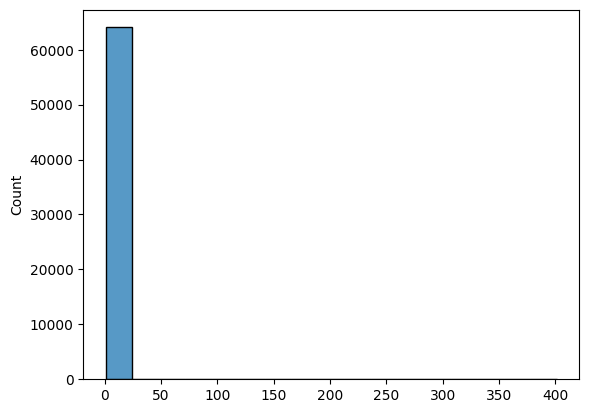

In [28]:
sns.histplot(np.sum(statement_vector, axis = 0))

Merge new features

In [29]:
train_data2 = pd.concat([train_data,statement_vector],axis=1)

In [30]:
train_data2.head()

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,...,st_zone_control,st_zone_decis,st_zone_name,st_zone_school,st_zone_texa,st_zoo_without,st_zuckerberg_less,st_zuckerberg_person,st_﻿say_joann,st_﻿﻿sinc_mayor
0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,0,0,0,0,0,0,0,0,0,0
3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,0,0,0,0,0,0,0,0,0,0
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0,0,0,0,0,0,0,0,0,0


Do the same for context. But there are 102 null present, drop them first.

In [31]:
sum(train_data2['context'].isnull())

102

Suppose null value for the context is caused by unknown source, replace them with "unknown".

In [32]:
# fill null context
train_data2["context"].fillna(value = "unknown", inplace=True)

In [33]:
train_data2['stemmed_context_token'] = tokenize_and_stem(train_data2['context']) # Process context strings

Check redundant:

In [34]:
words_in_context = countwords(train_data2["stemmed_context_token"])
print(words_in_context[0:20])

[('interview', 1754), ('speech', 1062), ('news', 864), ('campaign', 807), ('debat', 767), ('press', 686), ('releas', 677), ('post', 492), ('comment', 344), ('fox', 339), ('email', 336), ('radio', 335), ('confer', 300), ('meet', 299), ('televis', 298), ('state', 288), ('presidenti', 251), ('republican', 247), ('statement', 245), ('websit', 237)]


In [35]:
len(words_in_context)

1907

Apply vectorizer:

In [36]:
v_context = CountVectorizer(analyzer=lambda x: x, max_df = 1800 ,min_df = 50) # need analyzer=lambda x: x to disable the analyzer, since the input is pandas series of lists.
vectors = v_context.fit_transform(train_data2['stemmed_context_token'])
context_vector = new_features(vectors, 'ct', v_context)

In [37]:
context_vector.columns

Index(['ct_a_b_c', 'ct_a_d_d_r_e_s_s', 'ct_a_d_v_e_r_t_i_s', 'ct_a_p_p_e_a_r',
       'ct_a_r_t_i_c_l', 'ct_a_u_s_t_i_n', 'ct_b_l_o_g',
       'ct_b_r_o_a_d_c_a_s_t', 'ct_c_a_m_p_a_i_g_n', 'ct_c_b_s',
       'ct_c_h_a_i_n', 'ct_c_n_n', 'ct_c_o_l_u_m_n', 'ct_c_o_m_m_e_n_t',
       'ct_c_o_m_m_e_n_t_a_r_i', 'ct_c_o_m_m_e_r_c_i', 'ct_c_o_m_m_i_t_t_e',
       'ct_c_o_n_f_e_r', 'ct_c_o_n_v_e_n_t', 'ct_d_a_i_l_i', 'ct_d_e_b_a_t',
       'ct_d_e_m_o_c_r_a_t', 'ct_d_i_s_c_u_s_s', 'ct_e_m_a_i_l',
       'ct_e_v_e_n_t', 'ct_f_a_c_e', 'ct_f_a_c_e_b_o_o_k', 'ct_f_l_a',
       'ct_f_l_o_o_r', 'ct_f_l_o_r_i_d_a', 'ct_f_o_r_u_m', 'ct_f_o_x',
       'ct_f_u_n_d_r_a_i_s', 'ct_h_a_l_l', 'ct_h_a_m_p_s_h_i_r', 'ct_h_e_a_r',
       'ct_h_o_u_s', 'ct_i_n_t_e_r_n_e_t', 'ct_i_n_t_e_r_v_i_e_w',
       'ct_i_o_w_a', 'ct_j_o_u_r_n_a_l', 'ct_l_e_t_t_e_r', 'ct_m_a_i_l_e_r',
       'ct_m_e_d_i_a', 'ct_m_e_e_t', 'ct_m_e_s_s_a_g', 'ct_m_o_r_n',
       'ct_m_s_n_b_c', 'ct_n_a_t_i_o_n', 'ct_n_b_c', 'ct_n_e_w', 'ct_n_e_

<Axes: ylabel='Count'>

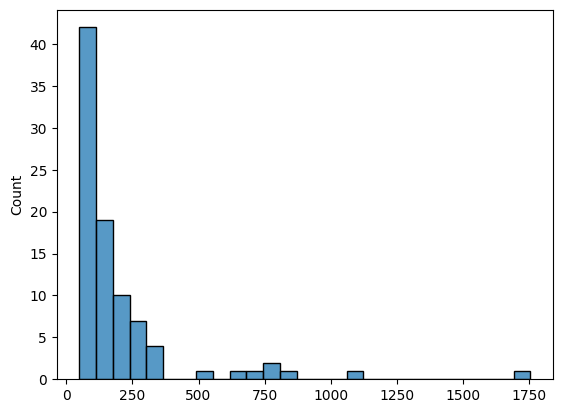

In [38]:
sns.histplot(np.sum(context_vector, axis = 0))

In [39]:
train_data3 = pd.concat([train_data2,context_vector],axis=1)
train_data3.shape

(10240, 64331)

Do the same for subject. Now, the tokens are separated by commas in this case. Thus, change them to spaces before tokenizing them.

In [40]:
sum(train_data3['subject'].isnull()) #check number of nulls

2

In [41]:
train_data3[train_data3['subject'].isnull()]

,ID,label_6,statement,subject,speaker,speaker_job,state,party,pof_count,false_count,...,ct_t_o_w_n,ct_t_w_e_e_t,ct_t_w_i_t_t_e_r,ct_u_n_i_o_n,ct_u_n_k_n_o_w_n,ct_v_i_d_e_o,ct_w_a_s_h_i_n_g_t_o_n,ct_w_e_b,ct_w_e_b_s_i_t,ct_w_e_e_k
2142,638.json,1,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
9375,1626.json,1,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


There are two nulls to get rid of. Replace them with "unknown".

In [42]:
# fill null subject
train_data3["subject"].fillna(value = "unknown", inplace=True)

Apply defined tokenizer:

In [43]:
train_data3['subject'].replace(',',' ',regex=True,inplace=True)  # turn commas to blank spaces
train_data3['stemmed_subject_token'] = tokenize_and_stem(train_data3['subject']) # Process subject strings

Check redundant:

In [44]:
words_in_subject = countwords(train_data3["stemmed_subject_token"])
print(words_in_subject[0:20])

[('economi', 1162), ('healthcar', 1128), ('tax', 994), ('federalbudget', 744), ('educ', 728), ('job', 711), ('statebudget', 696), ('candidatesbiographi', 653), ('elect', 607), ('immigr', 532), ('messagemachin', 494), ('foreignpolici', 471), ('crime', 446), ('histori', 405), ('energi', 382), ('legalissu', 344), ('environ', 336), ('gun', 330), ('militari', 315), ('jobaccomplish', 293)]


Apply CountVectorizer:

In [45]:
v_subject = CountVectorizer(analyzer=lambda x: x, max_df = 1.0 ,min_df = 50) # need analyzer=lambda x: x to disable the analyzer, since the input is pandas series of lists.
vectors = v_subject.fit_transform(train_data3['stemmed_subject_token'])
subject_vector = new_features(vectors, 'sj', v_subject)

In [46]:
subject_vector.columns

Index(['sj_a_b_c_n_e_w_s_w_e_e_k', 'sj_a_b_o_r_t', 'sj_a_f_g_h_a_n_i_s_t_a_n',
       'sj_a_g_r_i_c_u_l_t_u_r', 'sj_b_i_p_a_r_t_i_s_a_n_s_h_i_p',
       'sj_c_a_m_p_a_i_g_n_a_d_v_e_r_t_i_s', 'sj_c_a_m_p_a_i_g_n_f_i_n',
       'sj_c_a_n_d_i_d_a_t_e_s_b_i_o_g_r_a_p_h_i', 'sj_c_h_i_l_d_r_e_n',
       'sj_c_i_t_y_b_u_d_g_e_t', 'sj_c_i_t_y_g_o_v_e_r_n',
       'sj_c_i_v_i_l_r_i_g_h_t', 'sj_c_l_i_m_a_t_e_c_h_a_n_g',
       'sj_c_o_n_g_r_e_s_s', 'sj_c_o_n_g_r_e_s_s_i_o_n_a_l_r_u_l',
       'sj_c_o_r_p_o_r', 'sj_c_o_r_r_e_c_t_i_o_n_s_a_n_d_u_p_d',
       'sj_c_o_u_n_t_y_b_u_d_g_e_t', 'sj_c_o_u_n_t_y_g_o_v_e_r_n',
       'sj_c_r_i_m_e', 'sj_c_r_i_m_i_n_a_l_j_u_s_t_i_c', 'sj_d_e_b_a_t',
       'sj_d_e_b_t', 'sj_d_e_f_i_c_i_t', 'sj_d_i_v_e_r_s', 'sj_d_r_u_g',
       'sj_e_c_o_n_o_m_i', 'sj_e_d_u_c', 'sj_e_l_e_c_t', 'sj_e_n_e_r_g_i',
       'sj_e_n_v_i_r_o_n', 'sj_e_t_h_i_c', 'sj_f_a_m_i_l_i',
       'sj_f_e_d_e_r_a_l_b_u_d_g_e_t', 'sj_f_i_n_a_n_c_i_a_l_r_e_g_u_l',
       'sj_f_l_o_r_i_d_a', 'sj_f

<Axes: ylabel='Count'>

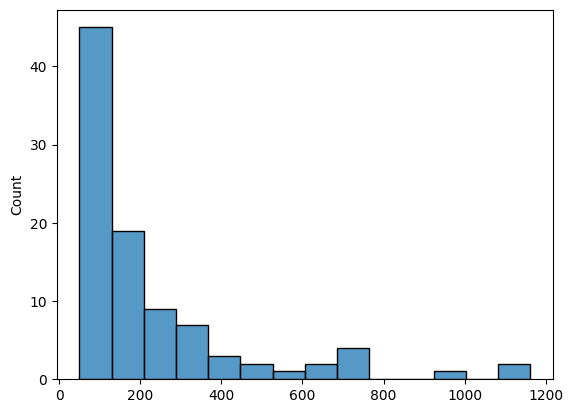

In [47]:
sns.histplot(np.sum(subject_vector, axis = 0))

In [48]:
train_data4 = pd.concat([train_data3,subject_vector],axis=1)

Drop original columns and get the final DataFrame:

In [49]:
train_data4.drop(columns=['statement', 'stemmed_statement_token','context', 'stemmed_context_token','subject', 'stemmed_subject_token'], inplace=True)

In [50]:
train_data4.shape

(10240, 64421)

In [51]:
train_data4.head(10)

,ID,label_6,speaker,speaker_job,state,party,pof_count,false_count,barelytrue_count,halftrue_count,...,sj_t_r_a_n_s_p_a_r,sj_t_r_a_n_s_p_o_r_t,sj_u_n_i_o_n,sj_v_e_t_e_r_a_n,sj_v_o_t_i_n_g_r_e_c_o_r_d,sj_w_a_t_e_r,sj_w_e_a_l_t_h,sj_w_e_l_f_a_r,sj_w_o_m_e_n,sj_w_o_r_k_e_r
0,2635.json,1,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10540.json,3,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,324.json,4,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,...,0,0,0,0,0,0,0,0,0,0
3,1123.json,1,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,9028.json,3,charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,...,0,0,0,0,0,0,0,0,0,0
5,12465.json,5,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
6,2342.json,2,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,153.json,3,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,...,0,0,0,0,0,0,0,0,0,0
8,5602.json,3,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,9741.json,4,duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,0


# Training Data Cleaning and Encoding

In [52]:
print(np.sum(train_data4.isnull(),axis = 0)) 

ID                   0
label_6              0
speaker              2
speaker_job       2898
state             2210
                  ... 
sj_w_a_t_e_r         0
sj_w_e_a_l_t_h       0
sj_w_e_l_f_a_r       0
sj_w_o_m_e_n         0
sj_w_o_r_k_e_r       0
Length: 64421, dtype: int64


First, we ignore the speaker's name and focus on their past speech counts. Even if the counts themselves may not determine if they will speak the truth in the future or not. But in terms of our work, they can serve as vectors determining who is which person. Then, for speaker jobs and their states, we deem that they are less likely to contribute to the model comparing to other atributes. Thus, let's verify if they are really the features to get rid of.

In [53]:
print('Speaker\'s job and states absolute correlation to 6-ways label:', np.abs(train_data4[['speaker_job','state']].corrwith(train_data4['label_6'],method= 'kendall')))
print('Speaker\'s jobs and states absolute correlation to 3-ways label:', np.abs(train_data4[['speaker_job','state']].corrwith(train_data4['label_3'],method= 'kendall')))
print('Speaker\'s jobs and states absolute correlation to 2-ways label:', np.abs(train_data4[['speaker_job','state']].corrwith(train_data4['label_2'],method= 'kendall')))

Speaker's job and states absolute correlation to 6-ways label: speaker_job    0.027761
state          0.033609
dtype: float64
Speaker's jobs and states absolute correlation to 3-ways label: speaker_job    0.033691
state          0.033827
dtype: float64
Speaker's jobs and states absolute correlation to 2-ways label: speaker_job    0.031046
state          0.023279
dtype: float64


Check if there is some individual feartures that are useful.

In [54]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(handle_unknown = 'ignore') #ignore tells the encoder to ignore new categories by encoding them with 0's
vectors = onehot.fit_transform(np.array(train_data4[['speaker_job','state']]))
speaker_vectors = new_features(vectors, 'speaker', onehot)

In [55]:
print('Top 5 speaker\'s job and state absolute correlation to 6-ways label:', np.abs(speaker_vectors.corrwith(train_data4['label_6'],method= 'pearson').nlargest(n=5)))
print('Top 5 speaker\'s job and state absolute correlation to 3-ways label:', np.abs(speaker_vectors.corrwith(train_data4['label_3'],method= 'pearson').nlargest(n=5)))
print('Top 5 speaker\'s job and state absolute correlation to 2-ways label:', np.abs(speaker_vectors.corrwith(train_data4['label_2'],method= 'pearson').nlargest(n=5)))

Top 5 speaker's job and state absolute correlation to 6-ways label: speaker_x_0___P_r_e_s_i_d_e_n_t                              0.075831
speaker_x_0___U_._S_._ _S_e_n_a_t_o_r                        0.073664
speaker_x_1___I_l_l_i_n_o_i_s                                0.072062
speaker_x_1___O_h_i_o                                        0.063330
speaker_x_0___P_r_e_s_i_d_e_n_t_i_a_l_ _c_a_n_d_i_d_a_t_e    0.060856
dtype: float64
Top 5 speaker's job and state absolute correlation to 3-ways label: speaker_x_0___U_._S_._ _S_e_n_a_t_o_r                        0.070963
speaker_x_0___P_r_e_s_i_d_e_n_t                              0.069477
speaker_x_1___I_l_l_i_n_o_i_s                                0.066647
speaker_x_0___P_r_e_s_i_d_e_n_t_i_a_l_ _c_a_n_d_i_d_a_t_e    0.059571
speaker_x_1___O_h_i_o                                        0.056732
dtype: float64
Top 5 speaker's job and state absolute correlation to 2-ways label: speaker_x_1___O_h_i_o                                        0.062

One can see that the correlations to the target class do not exceed 0.034. Also, there is no individual useful feature; thus, confirm our assumption that they are irrelavant. Proceed to drop them together with statement ID and speaker's name.

In [56]:
# drop unnescessary columns
train_data4.drop(columns = ['ID','speaker','speaker_job','state'],inplace = True)

Next, there are some null for the counts and party:

In [57]:
np.sum(train_data4[['pof_count','false_count','barelytrue_count','halftrue_count','mostlytrue_count']].isnull(),axis = 0)

pof_count           2
false_count         2
barelytrue_count    2
halftrue_count      2
mostlytrue_count    2
dtype: int64

In [58]:
np.sum(train_data['party'].isnull(),axis = 0)

2

Assume that these are caused by unknown speaker, simply set them to 0.

In [59]:
train_data4['pof_count'].fillna(0, inplace = True)
train_data4['false_count'].fillna(0, inplace = True)
train_data4['barelytrue_count'].fillna(0, inplace = True)
train_data4['halftrue_count'].fillna(0, inplace = True)
train_data4['mostlytrue_count'].fillna(0, inplace = True)

and assume "unknown" for the null in party.

In [60]:
train_data4['party'].fillna("unknown", inplace = True)

Check the party feature correlation to the target classes:

In [61]:
print('Speaker\'s party absolute correlation to 6-ways label:', np.abs(train_data4['party'].corr(train_data4['label_6'],method= 'kendall')))
print('Speaker\'s party absolute correlation to 3-ways label:', np.abs(train_data4['party'].corr(train_data4['label_3'],method= 'kendall')))
print('Speaker\'s party absolute correlation to 2-ways label:', np.abs(train_data4['party'].corr(train_data4['label_2'],method= 'kendall')))

Speaker's party absolute correlation to 6-ways label: 0.11078244905872753
Speaker's party absolute correlation to 3-ways label: 0.11787474723250836
Speaker's party absolute correlation to 2-ways label: 0.11491415720613446


Turns out our assumption about the party is wrong. The feature is not as useful as we thought. Nonetheless, let's investigate a little deeper if we can extract any useful feature. First, One-Hot encode party via scikit-learn module:

In [62]:
ohe = OneHotEncoder(handle_unknown = 'ignore') #ignore tells the encoder to ignore new categories by encoding them with 0's
vectors = ohe.fit_transform(np.array(train_data4['party']).reshape(-1, 1))
party_vector = new_features(vectors, 'party', ohe)

In [63]:
print('Top 5 speaker\'s party absolute correlation to 6-ways label:', np.abs(party_vector.corrwith(train_data4['label_6'],method= 'pearson').nlargest(n=5)))
print('Top 5 speaker\'s party absolute correlation to 3-ways label:', np.abs(party_vector.corrwith(train_data4['label_3'],method= 'pearson').nlargest(n=5)))
print('Top 5 speaker\'s party absolute correlation to 2-ways label:', np.abs(party_vector.corrwith(train_data4['label_2'],method= 'pearson').nlargest(n=5)))

Top 5 speaker's party absolute correlation to 6-ways label: party_x_0___d_e_m_o_c_r_a_t                  0.146585
party_x_0___i_n_d_e_p_e_n_d_e_n_t            0.045065
party_x_0___s_t_a_t_e_-_o_f_f_i_c_i_a_l      0.023415
party_x_0___n_e_w_s_m_a_k_e_r                0.019104
party_x_0___b_u_s_i_n_e_s_s_-_l_e_a_d_e_r    0.011591
dtype: float64
Top 5 speaker's party absolute correlation to 3-ways label: party_x_0___d_e_m_o_c_r_a_t                        0.140405
party_x_0___i_n_d_e_p_e_n_d_e_n_t                  0.049249
party_x_0___s_t_a_t_e_-_o_f_f_i_c_i_a_l            0.020773
party_x_0___e_d_u_c_a_t_i_o_n_-_o_f_f_i_c_i_a_l    0.016280
party_x_0___n_e_w_s_m_a_k_e_r                      0.016074
dtype: float64
Top 5 speaker's party absolute correlation to 2-ways label: party_x_0___d_e_m_o_c_r_a_t                        0.119210
party_x_0___i_n_d_e_p_e_n_d_e_n_t                  0.047645
party_x_0___b_u_s_i_n_e_s_s_-_l_e_a_d_e_r          0.019298
party_x_0___e_d_u_c_a_t_i_o_n_-_o_f_f_i_

The Democrat stands out from the other top 5 parties. Therefore, we decide to keep this in our model.

In [64]:
train_data4 = pd.concat([train_data4,party_vector['party_x0_democrat']],axis=1)
train_data4.drop(columns=['party'], inplace=True)

KeyError: 'party_x0_democrat'

In [ ]:
train_data4.head(10)

# Training, Valdiation and Test Sets Preparation

Apply BoW, vectorizer, and one-hot encoding to v and test set without word counts threshold and cut-offs. Then, mask the columns with ones from the training set, such that the columns that do not appear in the training set are dropped. For columns that do not exist in the v and test set, add them and set their values to zero.

In [ ]:
# fill nulls
v_data["subject"].fillna(value = "unknown", inplace=True)
v_data["context"].fillna(value = "unknown", inplace=True)
v_data['party'].fillna("unknown", inplace = True)
test_data["subject"].fillna(value = "unknown", inplace=True)
test_data["context"].fillna(value = "unknown", inplace=True)
test_data['party'].fillna("unknown", inplace = True)

v_data['pof_count'].fillna(0, inplace = True)
v_data['false_count'].fillna(0, inplace = True)
v_data['barelytrue_count'].fillna(0, inplace = True)
v_data['halftrue_count'].fillna(0, inplace = True)
v_data['mostlytrue_count'].fillna(0, inplace = True)

test_data['pof_count'].fillna(0, inplace = True)
test_data['false_count'].fillna(0, inplace = True)
test_data['barelytrue_count'].fillna(0, inplace = True)
test_data['halftrue_count'].fillna(0, inplace = True)
test_data['mostlytrue_count'].fillna(0, inplace = True)

In [ ]:
# tokenize statement
v_data["stemmed_statement_token"] = tokenize_and_stem(v_data['statement'])
test_data["stemmed_statement_token"] = tokenize_and_stem(test_data['statement'])

# tokenize context
v_data["stemmed_context_token"] = tokenize_and_stem(v_data['context'])
test_data["stemmed_context_token"] = tokenize_and_stem(test_data['context'])

# turn commas to blank spaces for subjects
v_data['subject'].replace(',',' ',regex=True,inplace=True) 
test_data['subject'].replace(',',' ',regex=True,inplace=True)  

# tokenize subject
v_data["stemmed_subject_token"] = tokenize_and_stem(v_data['subject'])
test_data["stemmed_subject_token"] = tokenize_and_stem(test_data['subject'])

Apply the countvectorizer based on what we have done for the training set via transform.

In [ ]:
def transformtovec(Pandas_Series, prefixstring, vectorizer):
    vectors = vectorizer.transform(Pandas_Series)
    vecdataframe = new_features(vectors, prefixstring, vectorizer)
    return vecdataframe

In [ ]:
# Statement
# get new DataFrame
v_statement_vectors = transformtovec(v_data["stemmed_statement_token"], 'st', v_statement)
test_statement_vectors = transformtovec(test_data["stemmed_statement_token"], 'st', v_statement)

# Context
# get new DataFrame
v_context_vectors = transformtovec(v_data["stemmed_context_token"], 'ct', v_context)
test_context_vectors = transformtovec(test_data["stemmed_context_token"], 'ct', v_context)

# Context
# get new DataFrame
v_subject_vectors = transformtovec(v_data["stemmed_subject_token"], 'sj', v_subject)
test_subject_vectors = transformtovec(test_data["stemmed_subject_token"], 'sj', v_subject)

In [ ]:
# merge the data in the same order as the training set

# cross validation set
v_data = pd.concat([v_data,v_statement_vectors],axis=1)
v_data = pd.concat([v_data,v_context_vectors],axis=1)
v_data = pd.concat([v_data,v_subject_vectors],axis=1)

# test set
test_data = pd.concat([test_data,test_statement_vectors],axis=1)
test_data = pd.concat([test_data,test_context_vectors],axis=1)
test_data = pd.concat([test_data,test_subject_vectors],axis=1)

# drop original and unnecessary columns
v_data.drop(columns=['ID','statement', 'stemmed_statement_token','context', 'stemmed_context_token','subject', 'stemmed_subject_token','speaker','speaker_job','state'], inplace=True)
test_data.drop(columns=['ID','statement', 'stemmed_statement_token','context', 'stemmed_context_token','subject', 'stemmed_subject_token','speaker','speaker_job','state'], inplace=True)

Get the Democrat One-Hot Feature:

In [ ]:
# validation
v_vectors = ohe.transform(np.array(v_data['party']).reshape(-1, 1))
v_party_vector = new_features(v_vectors, 'party', ohe)
v_data = pd.concat([v_data,v_party_vector['party_x0_democrat']],axis=1)
v_data.drop(columns=['party'], inplace=True)

# test
test_vectors = ohe.transform(np.array(test_data['party']).reshape(-1, 1))
test_party_vector = new_features(test_vectors, 'party', ohe)
test_data = pd.concat([test_data,test_party_vector['party_x0_democrat']],axis=1)
test_data.drop(columns=['party'], inplace=True)

Lastly, properly identify the independent and dependent variables.

In [ ]:
# features
X_train = train_data4.drop(columns = ['label_2','label_3','label_6'])
X_v = v_data.drop(columns = ['label_2','label_3','label_6'])
X_test = test_data.drop(columns = ['label_2','label_3','label_6'])

# targets
y_train = train_data4[['label_2','label_3','label_6']]
y_v = v_data[['label_2','label_3','label_6']]
y_test = test_data[['label_2','label_3','label_6']]

In [ ]:
label = 2 # label to metric: 0,1, 2 for 2, 3 and 6 ways respectively

# Naive Bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train.iloc[:,label])
y_pred = gnb.predict(X_v)

In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(y_v['label_6'], y_pred))

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_range = list(range(1, 250,10))
scores = []
scores2 = []
score_cv = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i,weights = 'distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_v)
    y_pred2 = knn.predict(X_test)
    cv_scores = cross_val_score(knn, X_train, y_train.iloc[:,label], cv=5)
    scores.append(metrics.accuracy_score(y_v.iloc[:,label], y_pred[:,label]))
    score_cv.append(cv_scores.mean())
    scores2.append(metrics.accuracy_score(y_test.iloc[:,label], y_pred2[:,label]))

plt.plot(k_range, scores, label = 'val')
plt.plot(k_range, score_cv, label = 'cv 5 fold')
plt.plot(k_range, scores2, label = 'test')
plt.legend()
plt.show()
print(np.transpose(np.array([k_range,np.around(scores2,7)*100])))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# n = 31
knn = KNeighborsClassifier(n_neighbors=91,weights = 'distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test.iloc[:,label],y_pred[:,label], labels=knn.classes_[label])
print(metrics.accuracy_score(y_test.iloc[:,label], y_pred[:,label]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_[label])
disp.plot()
plt.show()

In [ ]:
if plot_knn_accuracy:
    k_range = list(range(1, 100,5))
    score_train = []
    score_v = []
    score_test = []
    for i in k_range:
        knn = KNeighborsClassifier(n_neighbors=i, weights = 'distance',algorithm = 'brute',metric = 'manhattan')
        knn.fit(X_train, y_train)
        y_pred_train = knn.predict(X_train)
        v_scores = cross_val_score(knn, X_train, y_train, v=5)
        y_pred_test = knn.predict(X_test)
        score_train.append(metrics.accuracy_score(y_train, y_pred_train))
        score_v.append(v_scores.mean())
        score_test.append(metrics.accuracy_score(y_test, y_pred_test))
    
    np.array(score_train).tofile('KNN_score_train.csv', sep = ',')   
    np.array(score_v).tofile('KNN_score_v.csv', sep = ',')   
    np.array(score_test).tofile('KNN_score_test.csv', sep = ',') 

In [ ]:
if plot_knn_accuracy:
    score_train = pd.read_csv("/kaggle/working/KNN_score_train.csv", header = None)
    score_v = pd.read_csv("/kaggle/working/KNN_score_v.csv", header = None)
    score_test = pd.read_csv("/kaggle/working/KNN_score_test.csv", header = None)

    #k_range = list(range(1, 60,5))

    plt.plot(k_range, score_train.T ,label = 'train')
    plt.plot(k_range, score_v.T,label = 'v 5 fold')
    plt.plot(k_range, score_test.T,label = 'test')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('Accuracy score')
    plt.yscale('log')
    plt.show()

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

if plot_logreg_accuracy:
    order_range = np.arange(-4,-2,0.2)
    c_range = 10.0**order_range
    scores = []
    for c in c_range:
        logreg = LogisticRegression(random_state=0,C=c,max_iter = 500)
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_v)
        scores.append(metrics.accuracy_score(y_v, y_pred))

In [ ]:
if plot_logreg_accuracy:
    plt.plot(order_range, scores)
    plt.show()
    print(np.transpose(np.array([order_range,np.around(scores,7)*100])))

# Test

In [ ]:
train_data4.head(10).filter(regex='statement').columns

In [ ]:
train_data4.head(10)

In [ ]:
train_data4.head(10).filter(regex='statement')

In [ ]:
#sns.pairplot(train_data4[['pof_count','false_count','barelytrue_count','halftrue_count','mostlytrue_count','context_ad','label_2']],hue = 'label_2')

In [ ]:
from copy import deepcopy
df_test = deepcopy(train_data)
df_test['subject'] = train_data['subject'].mask(train_data.groupby('subject')['subject'].transform('size').lt(60), 'Others')
df_test.drop(df_test[df_test['subject'] ==  'Others'].index, inplace = True)

Show unique value for "context"

Show all rows that contain:

In [ ]:
np.sum(test_data.filter(regex='count').isnull(),axis = 0)